In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
%matplotlib inline

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [3]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

## Explore (train_set) AKA (train_loader.dataset)

In [4]:
print(train_set)             #trainset[IMAGEINDEX][0-image_tensor,1-class] [CHANNEL][HEIGHT][WIDTH]
print(train_set.data.shape)  #trainset.data[IMAGE INDEX][HEIGHT][WIDTH]

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
torch.Size([60000, 28, 28])


In [5]:
# SINGLE
image , label = next(iter(train_set))   # SAME AS train_set[0] - train_set IS INDEXABLE
print(image.shape)
print(label)

torch.Size([1, 28, 28])
9


In [6]:
# BATCH
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(train_loader)) #CANT USE train_loader[0] - NOT INDEXABLE
images , labels = batch          #LOADS 1 BATCH(10 images) AT ONCE
print(images.shape)

torch.Size([10, 1, 28, 28])


## Network & Training

In [7]:
class Network(nn.Module):
    
    def __init__(self, lr):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = F.cross_entropy
        
    def forward(self, t):
        #conv layer 1
        t = F.relu(self.conv1(t))        
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        #conv layer 2
        t = F.relu(self.conv2(t)) 
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        t = F.relu(self.fc1(t.reshape(-1, 12*4*4)))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        #t = F.softmax(t, dim=1)   #NO NEED BECAUSE LOSSFUNCTION AUTOMATICALL DOES CROSS ENTROPY
        
        return t

In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=200)
network = Network(lr = 0.01)
num_epochs = 8

In [9]:
config = {
    "dataset": "FashionMNIST",
    "model": "Custom CNN",
    "learning_rate": 0.01,
    "batch_size": 200,
    "num_epochs": 8
}

run = wandb.init(project="pytorch-course",
                 name="wandb-run-2",
                 tags=["pytorch","cnn","fashion-mnist"],
                 config=config)

wandb: Currently logged in as: nimishsantosh (use `wandb login --relogin` to force relogin)


In [10]:
for epoch in range(num_epochs):
    total_loss = 0
    
    for batch in train_loader:
        images, labels = batch
        preds = network(images)
        loss = network.loss(preds, labels) #calc loss
        
        network.optimizer.zero_grad()      #set gradients to zero
        loss.backward()                    #calc gradients
        network.optimizer.step()
        
        total_loss += loss.item()
    
    print("EPOCH: ",epoch,"   LOSS: ",total_loss)
    wandb.log({'EPOCH': epoch, 'LOSS': total_loss})
    
torch.save(network.state_dict(), './models/model1.pt')
wandb.save('./models/model1.pt')
run.finish()

EPOCH:  0    LOSS:  186.7149558365345
EPOCH:  1    LOSS:  117.18891496956348
EPOCH:  2    LOSS:  104.52210842072964
EPOCH:  3    LOSS:  98.10501804947853
EPOCH:  4    LOSS:  93.97693338990211
EPOCH:  5    LOSS:  90.02866977453232
EPOCH:  6    LOSS:  87.08223681151867
EPOCH:  7    LOSS:  85.24627235531807


EPOCH,7
LOSS,85.24627
_step,7
_runtime,199
_timestamp,1603881233


EPOCH,▁▂▃▄▅▆▇█
LOSS,█▃▂▂▂▁▁▁
_step,▁▂▃▄▅▆▇█
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█


## Confusion matrix / Analysis

In [11]:
print(len(train_set))
print(train_set.targets)

60000
tensor([9, 0, 0,  ..., 3, 0, 5])


In [12]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [14]:
with torch.no_grad():      #DONT TRACK COMPUTATIONS BECAUSE WE ARENT TRAINING
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)

train_preds.shape

torch.Size([60000, 10])

In [15]:
num_correct = get_num_correct(train_preds, train_set.targets)
print(num_correct)

53330


In [16]:
print("ACCURACY: ",num_correct / len(train_set))

ACCURACY:  0.8888333333333334


In [17]:
## FOR CONFUSION MATRIX
matrix = torch.zeros(10,10,dtype = torch.int32)

preds_argmax = train_preds.argmax(dim=1)
print(preds_argmax)
pred_labels = train_set.targets
print(pred_labels)

for i in range(len(preds_argmax)):
    matrix[pred_labels[i],preds_argmax[i]] += 1 #create matrix for every predictioin,label pair increment corresponding box in matrix

tensor([9, 0, 0,  ..., 3, 0, 5])
tensor([9, 0, 0,  ..., 3, 0, 5])


In [18]:
matrix

tensor([[5485,    2,   91,   79,    6,    1,  308,    0,   28,    0],
        [  40, 5698,    0,  229,    8,    2,   11,    0,   12,    0],
        [  68,    1, 4857,   44,  438,    1,  549,    0,   42,    0],
        [ 198,    2,   22, 5429,  192,    0,  146,    0,   11,    0],
        [  13,    1,  384,  164, 4795,    0,  597,    0,   46,    0],
        [   5,    0,    0,    0,    0, 5556,    0,  175,   18,  246],
        [1153,    4,  391,   82,  260,    1, 4008,    0,  101,    0],
        [   0,    0,    0,    0,    0,   16,    0, 5706,    5,  273],
        [  29,    0,    9,   15,    8,    2,   34,    4, 5899,    0],
        [   1,    0,    0,    0,    0,    3,    0,   99,    0, 5897]],
       dtype=torch.int32)

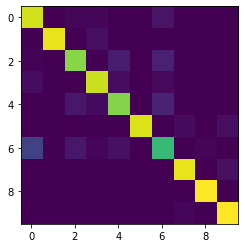

In [19]:
plt.imshow(matrix)